In [1]:
%matplotlib notebook
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split as tts
from sklearn.ensemble import ExtraTreesClassifier as ExTC
#from pprint import pprint
from sklearn import metrics
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
R2 = pd.read_csv('./surrogate_performance/benchmark_test_R^2.csv', index_col=0)
features = pd.read_csv('./features/benchmark_train.csv', index_col=0)

In [3]:
cv_max = pd.read_csv('./surrogate_performance/benchmarkCV-score-max.csv', index_col=0)
cv_mean = pd.read_csv('./surrogate_performance/benchmarkCV-score-mean.csv', index_col=0)

In [4]:
# Drop NANs
features.dropna(axis = 1, inplace=True)

In [5]:
# Drop columns with only one unique value
cols = features.select_dtypes([np.number]).columns
std = features[cols].std()
cols_to_drop = std[std==0].index
features = features.drop(cols_to_drop, axis=1)

In [6]:
# Drop columns with inf
features.replace([np.inf, -np.inf], np.nan, inplace=True)
features.dropna(axis = 1, inplace=True)

In [7]:
# Calculating Loss and Targets. Target is the modelling method with lowest loss.
loss = -R2.sub(R2.max(axis=1), axis=0)
targets = loss.idxmin(axis=1)

In [8]:
# Getting data that is avalable in both targets and features
features_available_for = targets.index.intersection(features.index)
targets = targets.loc[features_available_for]
######################
loss = loss.loc[features_available_for]

In [9]:
# Doing the same for cv_max and cv_mean

cv_max = cv_max.loc[features_available_for]
cv_mean = cv_mean.loc[features_available_for]
cv_mean_best = cv_mean.idxmax(axis=1)
cv_max_best = cv_max.idxmax(axis=1)

In [10]:
# Train test split
train_features, test_features, train_targets, test_targets = tts(features, targets)

In [11]:
# Training the selector
selector = ExTC()
selector.fit(train_features.values, train_targets.values)

/home/rishi/.virtualenvs/ModelSelector/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


ExtraTreesClassifier(bootstrap=False, class_weight=None, criterion='gini',
                     max_depth=None, max_features='auto', max_leaf_nodes=None,
                     min_impurity_decrease=0.0, min_impurity_split=None,
                     min_samples_leaf=1, min_samples_split=2,
                     min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=None,
                     oob_score=False, random_state=None, verbose=0,
                     warm_start=False)

In [12]:
predicted_targets = selector.predict(test_features)
predicted_targets = pd.DataFrame(predicted_targets, index=test_features.index, columns=['Prediction'])

<IPython.core.display.Javascript object>


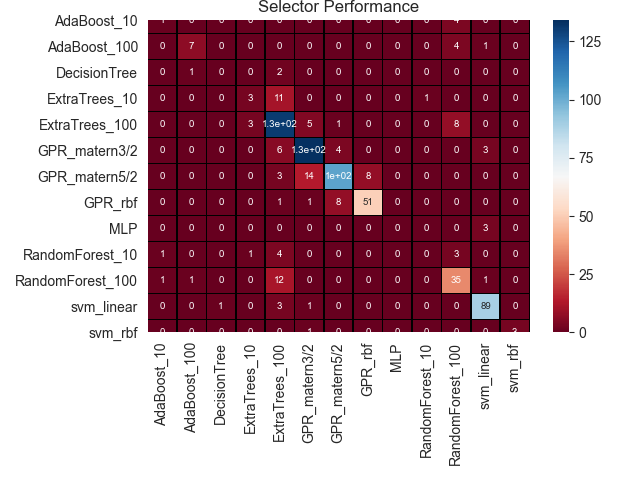

Text(0.5, 1, 'Selector Performance')

In [13]:
con_mat = metrics.confusion_matrix(test_targets, predicted_targets)
con_mat = pd.DataFrame(con_mat, index=selector.classes_, columns= selector.classes_)
sns.set_style("whitegrid")
sns.heatmap(con_mat,cmap="RdBu",annot=True,annot_kws={"size": 7},linewidths=0.5, linecolor='black')
plt.tight_layout()
plt.title('Selector Performance')

In [14]:
# For loss comparison
comparison_index = loss.index.intersection(predicted_targets.index)
loss_compare = loss.loc[comparison_index]
loss_prediction = pd.DataFrame(columns=['Prediction'], index=comparison_index, dtype=float)

In [15]:
for comp_id in comparison_index:
    loss_prediction['Prediction'].at[comp_id] = loss_compare[predicted_targets.loc[comp_id]].loc[comp_id]

In [16]:
loss_compare.sort_index(axis=1, inplace=True)
loss_compare = loss_compare.join(loss_prediction)

<IPython.core.display.Javascript object>


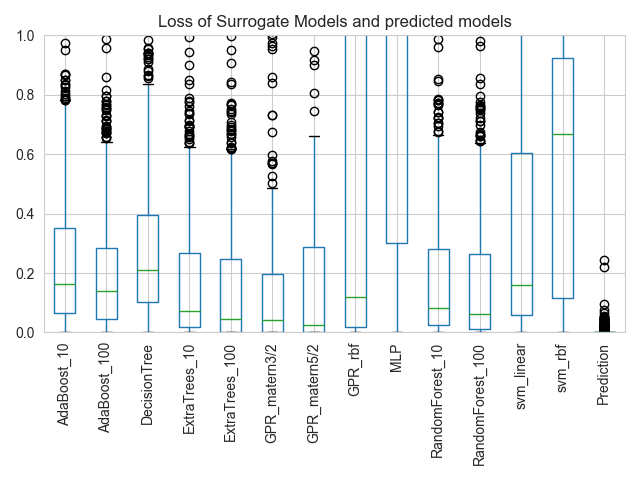

Prediction    0.023962
Name: 0.95, dtype: float64

In [17]:
loss_chart = loss_compare.boxplot(rot=90)
loss_chart.set_title('Loss of Surrogate Models and predicted models')
loss_chart.set_ylim([0,1])
plt.tight_layout()
loss_prediction.quantile(q=0.95)

In [18]:
# Direct Prediction with CV Values
loss_predictionCVmax = pd.DataFrame(columns=['CVmax'], index=comparison_index, dtype=float)
for comp_id in comparison_index:
    loss_predictionCVmax['CVmax'].at[comp_id] = loss_compare[cv_max_best.loc[comp_id]].loc[comp_id]

    
loss_predictionCVmean = pd.DataFrame(columns=['CVmean'], index=comparison_index, dtype=float)
for comp_id in comparison_index:
    loss_predictionCVmean['CVmean'].at[comp_id] = loss_compare[cv_mean_best.loc[comp_id]].loc[comp_id]

In [19]:
loss_compare = loss_compare.join(loss_predictionCVmax)
loss_compare = loss_compare.join(loss_predictionCVmean)

<IPython.core.display.Javascript object>


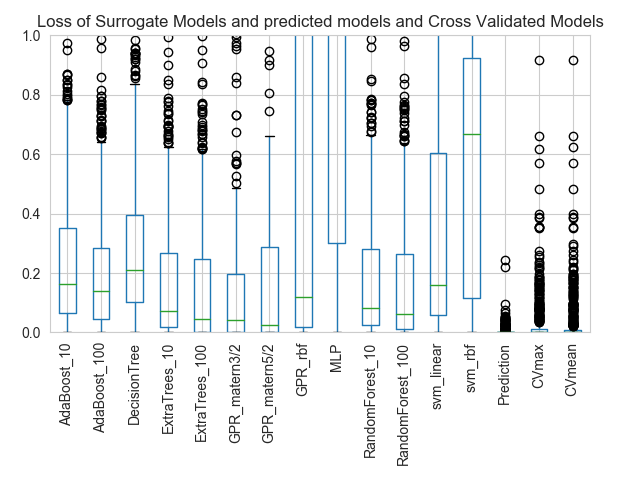

Prediction    0.023962
Name: 0.95, dtype: float64

In [20]:
loss_chart = loss_compare.boxplot(rot=90)
loss_chart.set_title('Loss of Surrogate Models and predicted models and Cross Validated Models')
loss_chart.set_ylim([0,1])
plt.tight_layout()
loss_prediction.quantile(q=0.95)

<IPython.core.display.Javascript object>


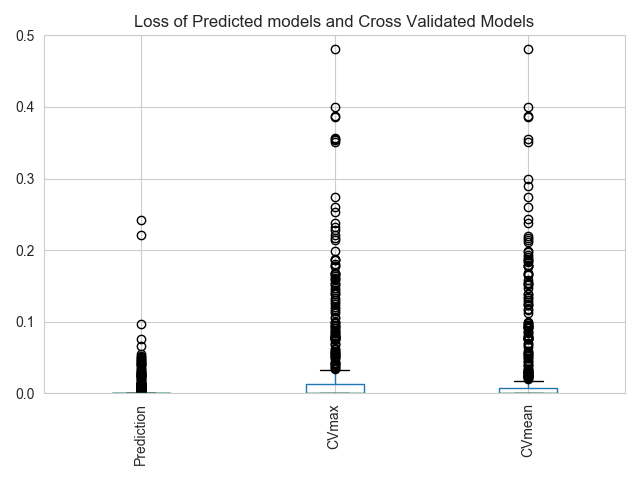

Prediction    0.023962
Name: 0.95, dtype: float64

In [21]:
loss_chart = loss_compare[['Prediction', 'CVmax', 'CVmean']].boxplot(rot=90)
loss_chart.set_title('Loss of Predicted models and Cross Validated Models')
loss_chart.set_ylim([0,0.5])
plt.tight_layout()
loss_prediction.quantile(q=0.95)

In [22]:
loss_compare.describe()

,AdaBoost_10,AdaBoost_100,DecisionTree,ExtraTrees_10,ExtraTrees_100,GPR_matern3/2,GPR_matern5/2,GPR_rbf,MLP,RandomForest_10,RandomForest_100,svm_linear,svm_rbf,Prediction,CVmax,CVmean
count,679.000000,679.000000,679.000000,679.000000,679.000000,679.000000,679.000000,679.000000,679.000000,679.000000,679.000000,679.000000,679.000000,679.000000,679.000000,679.000000
mean,0.265251,0.226136,0.305324,0.194573,0.178451,0.700315,1.320924,21.243753,3.603862,0.205159,0.191800,0.353343,0.598963,0.003389,0.179699,0.167751
std,0.297576,0.283898,0.298394,0.279044,0.280570,2.594425,5.643936,88.997908,5.446030,0.284429,0.286135,0.403733,0.499687,0.015737,1.029073,0.954771
min,-0.000000,-0.000000,-0.000000,-0.000000,-0.000000,-0.000000,-0.000000,-0.000000,-0.000000,-0.000000,-0.000000,-0.000000,-0.000000,-0.000000,-0.000000,-0.000000
25%,0.064578,0.043540,0.102392,0.018653,0.000001,0.000001,0.000297,0.016698,0.301677,0.025693,0.012209,0.060253,0.116041,-0.000000,-0.000000,-0.000000
50%,0.163402,0.137975,0.211486,0.070545,0.045764,0.041165,0.025350,0.119556,1.061655,0.083822,0.062094,0.159539,0.666408,-0.000000,-0.000000,-0.000000
75%,0.352026,0.282756,0.396713,0.266079,0.246418,0.196557,0.288471,3.234593,4.175549,0.281819,0.265023,0.604579,0.924908,-0.000000,0.013123,0.006879
max,1.752426,1.706024,1.654476,1.625833,1.634261,56.224255,59.721012,640.288571,32.663551,1.659299,1.667530,3.707345,2.579800,0.242377,10.816612,10.433311


## Saving the model

In [23]:
import pickle

with open('./results/selector.pkl', 'wb') as f:
    pickle.dump(selector, f)

## Analysis of loss

In [24]:
# To get the problem characteristics out of the filename:

columns = {'ProblemName':0, 'num_var':1, 'num_samples':2, 'distribution':3}

characteristics = pd.DataFrame(index=loss_prediction.index, columns=columns)
for index in characteristics.index:
    for column in columns:
        characteristics[column][index] = index.split('.')[0].split('_')[columns[column]]
characteristics['num_var'] = characteristics['num_var'].astype(int)
characteristics['num_samples'] = characteristics['num_samples'].astype(int)

selector_performance = characteristics.join(loss_prediction)

selector_performance.head()

,ProblemName,num_var,num_samples,distribution,Prediction
DTLZ4_16_250_normal.csv,DTLZ4,16,250,normal,-0.0
WFG1_30_900_uniform.csv,WFG1,30,900,uniform,-0.0
WFG4_20_150_normal.csv,WFG4,20,150,normal,-0.0
WFG7_20_350_uniform.csv,WFG7,20,350,uniform,-0.0
DTLZ5_6_600_normal.csv,DTLZ5,6,600,normal,-0.0


In [25]:
selector_performance.describe()

,num_var,num_samples,Prediction
count,679.000000,679.000000,679.000000
mean,16.686303,657.805596,0.003389
std,8.301489,496.408384,0.015737
min,6.000000,100.000000,-0.000000
25%,10.000000,250.000000,-0.000000
50%,16.000000,500.000000,-0.000000
75%,20.000000,900.000000,-0.000000
max,30.000000,2000.000000,0.242377


<IPython.core.display.Javascript object>


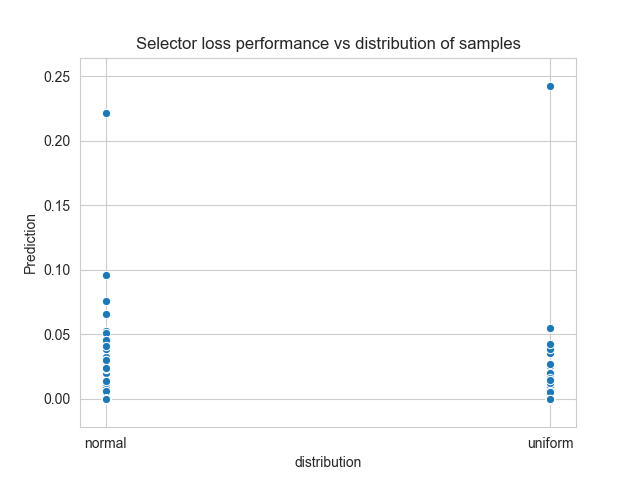

Text(0.5, 1.0, 'Selector loss performance vs distribution of samples')

In [26]:
sns.scatterplot(x='distribution', y='Prediction', data=selector_performance)
plt.title('Selector loss performance vs distribution of samples')

<IPython.core.display.Javascript object>


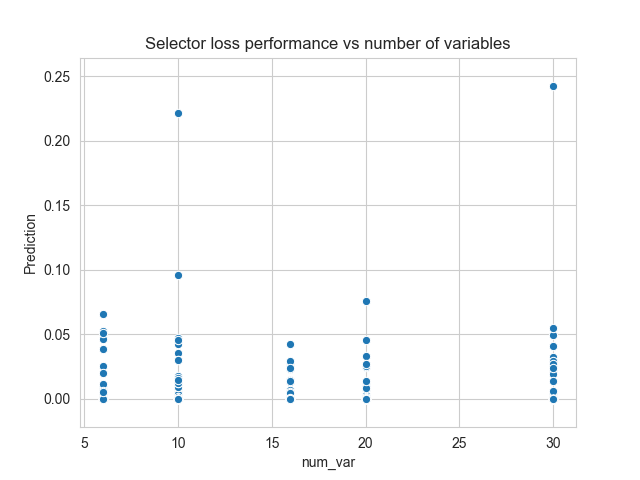

Text(0.5, 1.0, 'Selector loss performance vs number of variables')

In [27]:
sns.scatterplot(x='num_var', y='Prediction', data=selector_performance)
plt.title('Selector loss performance vs number of variables')

<IPython.core.display.Javascript object>


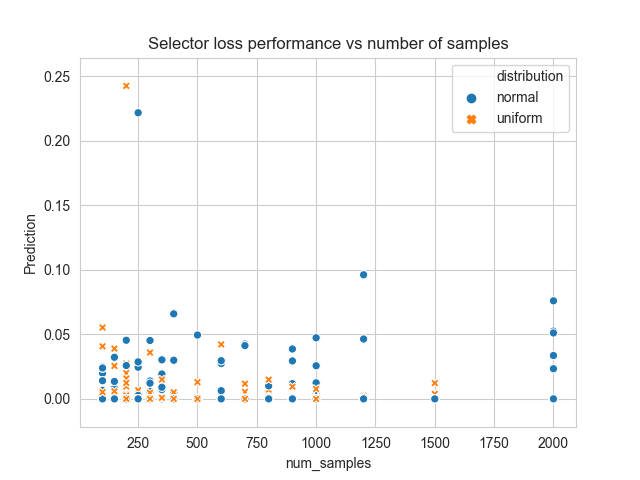

In [28]:
sns.scatterplot(x='num_samples', y='Prediction', hue='distribution', style='distribution', data=selector_performance)
plt.title('Selector loss performance vs number of samples')
plt.legend(loc='upper right')

<IPython.core.display.Javascript object>


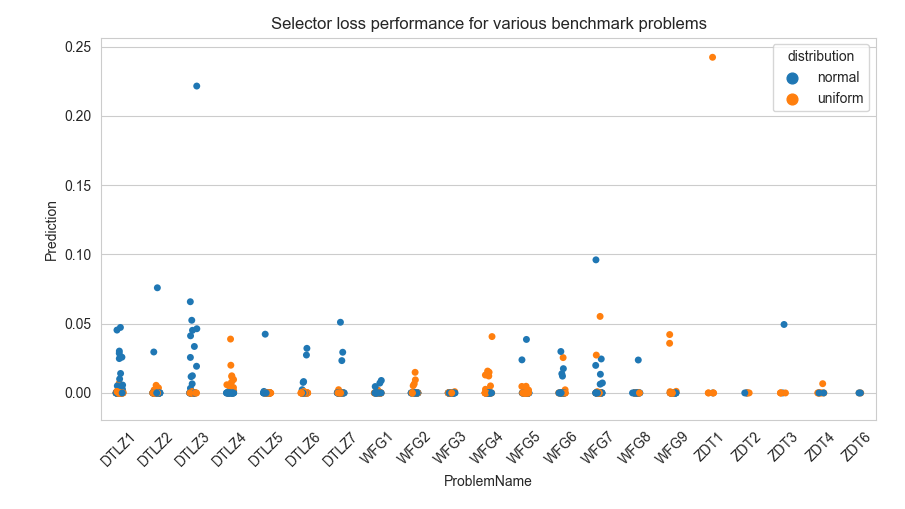

In [30]:
sns.stripplot(x='ProblemName',
              y='Prediction',
              hue='distribution',
              order=np.sort(selector_performance["ProblemName"].unique()),
              data=selector_performance)
#sns.boxplot(x='ProblemName', y='CVmean', data=CV_data[CV_data['distribution']=='uniform'])
#sns.catplot(x='ProblemName', y='CVmean',row='distribution', kind='box', data=CV_data)
plt.xticks(rotation=45)
plt.title('Selector loss performance for various benchmark problems')
plt.tight_layout()

<IPython.core.display.Javascript object>


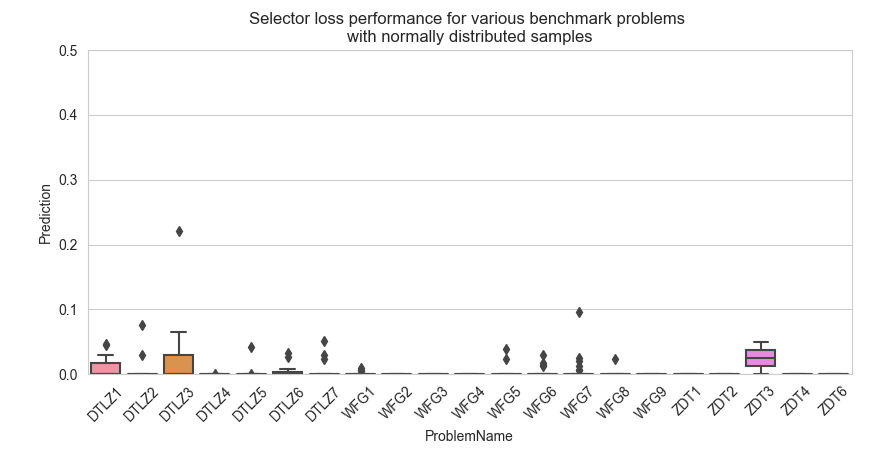

In [31]:
#sns.scatterplot(x='ProblemName', y='CVmean', hue='distribution', style='distribution', data=CV_data)
sns.boxplot(x='ProblemName',
            y='Prediction',
            order=np.sort(selector_performance["ProblemName"].unique()),
            data=selector_performance[selector_performance['distribution']=='normal'])
plt.xticks(rotation=45)
plt.ylim([0,0.5])
plt.title('Selector loss performance for various benchmark problems \nwith normally distributed samples')
plt.tight_layout()

In [32]:
loss_predictionCVmax = pd.DataFrame(columns=['CVmax'], index=selector_performance.index, dtype=float)
for comp_id in selector_performance.index:
    loss_predictionCVmax['CVmax'].at[comp_id] = loss[cv_max_best.loc[comp_id]].loc[comp_id]
    
loss_predictionCVmean = pd.DataFrame(columns=['CVmean'], index=selector_performance.index, dtype=float)
for comp_id in selector_performance.index:
    loss_predictionCVmean['CVmean'].at[comp_id] = loss[cv_mean_best.loc[comp_id]].loc[comp_id]

In [33]:
selector_performance = selector_performance.join(loss_predictionCVmax)
selector_performance = selector_performance.join(loss_predictionCVmean)

<IPython.core.display.Javascript object>


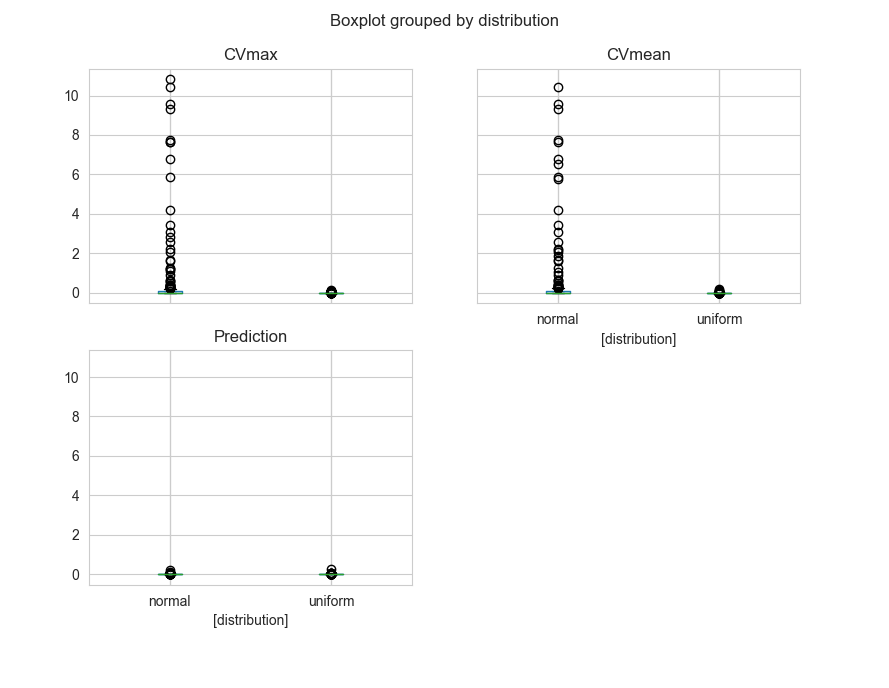

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f4591a79150>,
      dtype=object)

In [34]:
selector_performance[['Prediction', 'CVmax', 'CVmean', 'distribution']].boxplot(by='distribution')

## Feature Importances

In [35]:
importances = selector.feature_importances_
std = np.std([tree.feature_importances_ for tree in selector.estimators_],
             axis=0)
feat_importance = pd.DataFrame(np.vstack((importances, std)), columns=features.columns, index=['mean', 'std'])

/home/rishi/.virtualenvs/ModelSelector/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning: by argument to sort_index is deprecated, please use .sort_values(by=...)
  """Entry point for launching an IPython kernel.


<IPython.core.display.Javascript object>


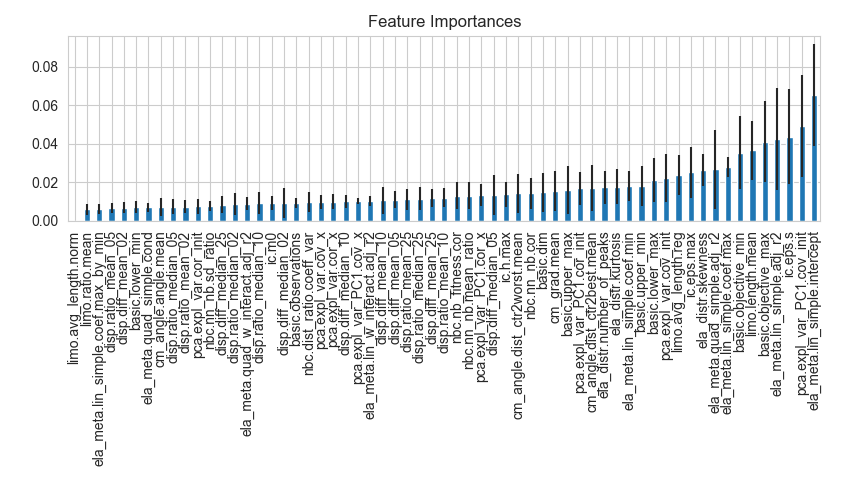

In [36]:
feat_importance.sort_index(by=['mean'], axis=1, inplace=True)
fig = feat_importance.loc['mean'].plot.bar(yerr=feat_importance.loc['std'])
plt.title('Feature Importances')
plt.tight_layout()